#Second Practical work

This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data
4.   GPU load





#### Elena Sánchez Guillán 100432523
#### Ekaterina Valverde Bilenko 100432515

##Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [ ]:
!pip install pycuda

We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [ ]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
from sys import getsizeof
import time

In [ ]:
%pylab inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

Populating the interactive namespace from numpy and matplotlib


##Mount Google Drive and access grant
We use Google API to allow access to our Google Drive.

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [ ]:
from os.path import join
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MYDRIVE="/content/drive/My Drive/"

**List Files in Folders**

In [ ]:
!ls /content/drive/My\ Drive/images/

chess.jpg  cloudsonjupi.jpg  digits.jpg  fence.jpg  hand-x-ray.jpg


We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [ ]:
IMAGE=join(MYDRIVE,"images/chess.jpg")

In [ ]:
print("Image to load: {0}".format(IMAGE))

Image to load: /content/drive/My Drive/images/chess.jpg


Loads an image in a numpy variable, and show.

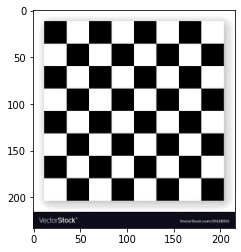

In [ ]:
image=np.array(Image.open(IMAGE))
plt.figure()
plt.imshow(image)

In [ ]:
print(image.shape)

(233, 216, 3)


#FILTER KERNEL

Here you have to define your image_filter GPU kernel.

And import the kernel definition to python

In [ ]:
template_kernel_matrix_univ = """
__global__ void image_filter( float * image,          //Source GPU array floating point 32 bits,
		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
                              float * filtered_image,  //Target GPU array 2D floating point 32 bits,
                              int NumRowsImg,         //Image Numrows,
                              int NumColsImg,         //Int32 Image Numcolumns,
                              int NumRowsFilter,       //Int32 Image NumRows filter mask,
                              int NumColsFilter       //Int32 Image NumCols filter mask
                              ) 
{ 

  //THIS CODE JUST COPY THE SOURCE IMAGE IN THE TARGET VECTOR
  int idxY;
  int idxX;
  int vX;

  idxY = blockIdx.y*blockDim.y+threadIdx.y; //With this we calculate the row address in target matrix
  idxX = blockIdx.x*blockDim.x+threadIdx.x;
  if ((idxY<NumRowsImg) && (idxX<NumColsImg)){
    vX=idxY*NumColsImg+idxX;
    // filtered_image is the shared memory array
    filtered_image[vX]=image[vX];
  }


  //if the size of the filter is 1x3, if it has 1 row and 3 columns 
  if (NumRowsFilter==1 && NumColsFilter==3){

    //This instruction calculate in the offset in the memory data, based on the block identificator blockIdx.x
    // YOU HAVE TO WRITE HERE YOUR FILTER KERNEL USING TILED MEMORY ALGORITHMS

    //as in the main part where we execute the filter we already go through the layers of the image we have to go through rows and columns in the kernel
    //first we iterate through the rows of the image 
    for (int i = 0; i < NumRowsImg; i++){
      //now we iterate through the columns of the image
      for (int j = 0; j < NumColsImg; j++){

        //now we can go through all the pixels so we can filter all of them

        //Set the row and column value for each thread, so we have the position
	      int row = blockIdx.y * blockDim.y + threadIdx.y + i;
	      int col = blockIdx.x * blockDim.x + threadIdx.x + j;

        //we have to create the shared memory space were we will store the data we need
	      __shared__ float sharedmem[(%(TILE_SIZE)s + 2)][(%(TILE_SIZE)s + 2)];  //initialize shared memory

	      //Take some values in order to see if we are in the first column or in the last column
	      bool is_x_left = (col == 0), is_x_right = (col == NumColsImg -1);
        
        //we store in the shared memory the position in which we are in (the pixel in which we are)
        sharedmem[threadIdx.x+1][threadIdx.y+1] = image[row*NumColsImg+col];

        //if we are in the first column we cannot take the value of the pixel in the previous column so we take the one in which we are
        if (is_x_left)
          sharedmem[threadIdx.x][threadIdx.y+1] = image[row*NumColsImg+col];
        //if we are not in the first column we can take the value of the pixel in the previous column
        else
          sharedmem[threadIdx.x][threadIdx.y+1] = image[row*NumColsImg+(col-1)];
        //if we are in the last column we cannot take the value of the pixel in the next column so we take the value of the pixel in which we are in
        if (is_x_right)
          sharedmem[threadIdx.x+2][threadIdx.y+1] = image[row*NumColsImg+col];
        //if not we can take the value of the pixel in the next column 
        else
          sharedmem[threadIdx.x+2][threadIdx.y+1] = image[row*NumColsImg+(col+1)];

        //we have to synchronize the threads in order to avoid interferences
	      __syncthreads();   //Wait for all threads to be done.

        //we declare a variable in which we will store the new result of the pixel, the new value that we will take
        float sum = 0;
        //we store in that variable the sum of the pixels we need
        //in this case, given that is a 1x3 filter we need the pixel in the previous column in that same row, the pixel we are filtering and the pixel in the next column in that same row
        //we multiply this pixels by the corresponding value in the filter
        sum += sharedmem[threadIdx.x][threadIdx.y+1]*filter_mask[0];
        sum += sharedmem[threadIdx.x+1][threadIdx.y+1]*filter_mask[1];
        sum += sharedmem[threadIdx.x+2][threadIdx.y+1]*filter_mask[2];

        //then we compute the mean by dividing by the total number of pixels we are using (3)
        sum = sum/3;

        //finally we insert the new value in the corresponding position in the filtered image
        //we first make sure that we are in a valid memory position
        if (row < NumRowsImg && col < NumColsImg)
          filtered_image[row*NumColsImg+col] = sum;
      }
    }
  }

  //if the size of the filter is 3x1, if it has 3 rows and 1 column 
  if (NumRowsFilter==3 && NumColsFilter==1){

    //first we iterate through the rows of the image 
    for (int i = 0; i < NumRowsImg; i++){
      //now we iterate through the columns of the image
      for (int j = 0; j < NumColsImg; j++){

        //now we can go through all the pixels so we can filter all of them
        //Set the row and column value for each thread, so we have the position
	      int row = blockIdx.y * blockDim.y + threadIdx.y + i;
	      int col = blockIdx.x * blockDim.x + threadIdx.x + j;

        //we have to create the shared memory space were we will store the data we need
	      __shared__ float sharedmem[(%(TILE_SIZE)s + 2)][(%(TILE_SIZE)s + 2)];  //initialize shared memory
	      //Take some values.

        //Take some values in order to see if we are in the first row or in the last row
	      bool is_y_top = (row == 0), is_y_bottom = (row == NumRowsImg -1);
        
        //we store in our shared memory the position in which we are in 
        sharedmem[threadIdx.x][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the first row we cannot take the value of the pixel in the previous row so we take the one in which we are
        if (is_y_top)
          sharedmem[threadIdx.x][threadIdx.y-1] = image[row*NumColsImg+col];
        //if not we take the value of the pixel of the previous row in the column in which we are
        else
          sharedmem[threadIdx.x][threadIdx.y-1] = image[(row-1)*NumColsImg+col];
        //if we are in the last row we cannot take the value of the pixel in the next row so we take the one in which we are
        if (is_y_bottom)
          sharedmem[threadIdx.x][threadIdx.y+1] = image[row*NumColsImg+col];
        //if not we take the value of the pixel of the next row in the column in which we are
        else
          sharedmem[threadIdx.x][threadIdx.y+1] = image[(row+1)*NumColsImg+col];

        //Now we have to synchronize the threads in order to avoid interferences
	      __syncthreads();   //Wait for all threads to be done.
        
        //we declare a variable in which we will store the new result of the pixel, the new value that we will take
        //in this case, given that is a 3x1 filter we need the pixel in the previous row in that same column, the pixel we are filtering and the pixel in the next row in that same column
        //we multiply each of these values for the corresponding value in the filter
        float sum = 0;
        sum += sharedmem[threadIdx.x][threadIdx.y-1]*filter_mask[0];
        sum += sharedmem[threadIdx.x][threadIdx.y]*filter_mask[1];
        sum += sharedmem[threadIdx.x][threadIdx.y+1]*filter_mask[2];
        sum = sum/3;
        
        //finally we insert the new value in the corresponding position in the filtered image
        //we first make sure that we are in a valid memory position
        if (row < NumRowsImg && col < NumColsImg)
          filtered_image[row*NumColsImg+col] = sum;

      }
    }
  }

  //now if the filter has 1 row and 5 columns
  if (NumRowsFilter==1 && NumColsFilter==5){
    
    //we first iterate through the rows
    for (int i = 0; i < NumRowsImg; i++){
      //then we iterate through the columns
      for (int j = 0; j < NumColsImg; j++){
        
        //Set the row and col value for each thread so we have the pixel's position
	      int row = blockIdx.y * blockDim.y + threadIdx.y + i;
	      int col = blockIdx.x * blockDim.x + threadIdx.x + j;

        //we create the shared space in which we will store the necessary data
	      __shared__ float sharedmem[%(TILE_SIZE)s + 2][%(TILE_SIZE)s + 2];  //initialize shared memory

	      //We have to check if we are in the first column or in the in the last column
	      bool is_x_left = (col == 0), is_x_right = (col == NumColsImg -1);
        
        //we store the value of the current position of the filter in our shared memory
        sharedmem[threadIdx.x][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the first column we cannot take the values from previous columns so we store the one in which we are in
        if (is_x_left){
          sharedmem[threadIdx.x-1][threadIdx.y] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x-2][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the column which is the next one to the first one, we can take the value of the pixel in the previous column, but not the one in the previous to the previous
        //therefore we store for both values the value of the pixel in that row in the previous column
        }else if ((col-1)==0){
          sharedmem[threadIdx.x-1][threadIdx.y] = image[row*NumColsImg+(col-1)];
          sharedmem[threadIdx.x-2][threadIdx.y] = image[row*NumColsImg+(col-1)];
        //else we can store both the values of the pixels in that row in the previous column and the previous to the previous column
        }else{
          sharedmem[threadIdx.x-1][threadIdx.y] = image[row*NumColsImg+(col-1)];
          sharedmem[threadIdx.x-2][threadIdx.y] = image[row*NumColsImg+(col-2)];
        //if we are in the last column we cannot take the values from previous columns so we store the one in which we are in
        }
        if (is_x_right){
          sharedmem[threadIdx.x+1][threadIdx.y] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x+2][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the column which is the next one to the last one, we can take the value of the pixel in the next column, but not the one in the next to the next
        //therefore we store for both values the value of the pixel in that row in the next column
        }else if ((col+1)==(NumColsImg-1)){
          sharedmem[threadIdx.x+1][threadIdx.y] = image[row*NumColsImg+(col+1)];
          sharedmem[threadIdx.x+2][threadIdx.y] = image[row*NumColsImg+(col+1)];
        //else we can store both the values of the pixels in that row in the next column and the next to the next column
        }else{
          sharedmem[threadIdx.x+1][threadIdx.y] = image[row*NumColsImg+(col+1)];
          sharedmem[threadIdx.x+2][threadIdx.y] = image[row*NumColsImg+(col+2)];
        }

        //we synchronize the threads so there is no interference
	      __syncthreads();   //Wait for all threads to be done.

        //we initialize the variable in which we will store the new value the pixel will take
        float sum = 0;
        //as this is a 1x5 filter we need the values of the pixels (all in the same row) of the previous to the previous column, the previous column, the one in which we are, the next column and the next to the next column 
        //we multiply each of these values for the corresponding value in the filter
        sum += sharedmem[threadIdx.x-2][threadIdx.y]*filter_mask[0];
        sum += sharedmem[threadIdx.x-1][threadIdx.y]*filter_mask[1];
        sum += sharedmem[threadIdx.x][threadIdx.y]*filter_mask[2];
        sum += sharedmem[threadIdx.x+1][threadIdx.y]*filter_mask[3];
        sum += sharedmem[threadIdx.x+1][threadIdx.y]*filter_mask[4];
        //we divide this value by 5 in order to compute the mean
        sum = sum/5;
        //we have to check if the memory position is valid
        if (row < NumRowsImg && col < NumColsImg)
          //if it is we store the new value in the corresponding position in the filtered image 
          filtered_image[row*NumColsImg+col] = sum;
      }
    }
  }

  //if the filter has 5 rows and 1 column
  if (NumRowsFilter==5 && NumColsFilter==1){

    //we iterate through the rows
    for (int i = 0; i < NumRowsImg; i++){
      //we iterate through the columns
      for (int j = 0; j < NumColsImg; j++){

        //Set the row and col value for each thread so we have the position
	      int row = blockIdx.y * blockDim.y + threadIdx.y + i;
	      int col = blockIdx.x * blockDim.x + threadIdx.x + j;

        //we initilaize the shared space where we will store the values we need
	      __shared__ float sharedmem[%(TILE_SIZE)s + 2][%(TILE_SIZE)s + 2];  //initialize shared memory

	      //We have to check if we are in the first or last row
	      bool is_y_top = (row == 0), is_y_bottom = (row == NumRowsImg -1);
        
        //we store in its corresponding position the value of the pixel in which we are in
        sharedmem[threadIdx.x][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the first row we cannot take the values from previous rows so we store the one in which we are in
        if (is_y_top){
          sharedmem[threadIdx.x][threadIdx.y-1] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y-2] = image[row*NumColsImg+col];
        //if we are in the row which is the next one to the first one, we can take the value of the pixel in the previous row, but not the one in the previous to the previous
        //therefore we store for both values the value of the pixel in that column in the previous row
        }else if ((row-1)==0){
          sharedmem[threadIdx.x][threadIdx.y-1] = image[(row-1)*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y-2] = image[(row-1)*NumColsImg+col];
        //else we can store both the values of the pixels in that column in the previous row and the previous to the previous row
        }else{
          sharedmem[threadIdx.x][threadIdx.y-1] = image[(row-1)*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y-2] = image[(row-2)*NumColsImg+col];
        }
        //if we are in the last row we cannot take the values from previous rows so we store the one in which we are in
        if (is_y_bottom){
          sharedmem[threadIdx.x][threadIdx.y+1] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y+2] = image[row*NumColsImg+col];
        //if we are in the row which is the next one to the first one, we can take the value of the pixel in the next row, but not the one in the next to the next
        //therefore we store for both values the value of the pixel in that column in the next row
        }else if ((row+1)==(NumRowsImg-1)){
          sharedmem[threadIdx.x][threadIdx.y+1] = image[(row+1)*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y+2] = image[(row+1)*NumColsImg+col];
        //else we can store both the values of the pixels in that column in the next row and the next to the next row
        }else{
          sharedmem[threadIdx.x][threadIdx.y+1] = image[(row+1)*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y+2] = image[(row+2)*NumColsImg+col];
        }

        //we synchronize the threads so there is no interference
	      __syncthreads();   //Wait for all threads to be done.

        //we initialize the variable in which we will store the new value the pixel will take
        float sum = 0;
        //as this is a 5x1 filter we need the values of the pixels (all in the same column) of the previous to the previous row, the previous row, the one in which we are, the next row and the next to the next row 
        //we multiply each of these values for the corresponding value in the filter
        sum += sharedmem[threadIdx.x][threadIdx.y-2]*filter_mask[0];
        sum += sharedmem[threadIdx.x][threadIdx.y-1]*filter_mask[1];
        sum += sharedmem[threadIdx.x][threadIdx.y]*filter_mask[2];
        sum += sharedmem[threadIdx.x][threadIdx.y+1]*filter_mask[3];
        sum += sharedmem[threadIdx.x][threadIdx.y+2]*filter_mask[4];
        //we divide this value by 5 in order to compute the mean
        sum = sum/5;
        
        //we have to check if the memory position is valid
        if (row < NumRowsImg && col < NumColsImg)
          //if it is we store the new value in the corresponding position in the filtered image 
          filtered_image[row*NumColsImg+col] = sum;
      }
    }
  }

  //Now if the filter is a 3x3 filter
  if (NumRowsFilter==3 && NumColsFilter==3){

    //we iterate through the rows
    for (int i = 0; i < NumRowsImg; i++){
      //we iterate through the columns
      for (int j = 0; j < NumColsImg; j++){

        //Set the row and col value for each thread so we have the current position
	      int row = blockIdx.y * blockDim.y + threadIdx.y + i;
	      int col = blockIdx.x * blockDim.x + threadIdx.x + j;

        //we create a shared space in which we will store the data we will use 
	      __shared__ float sharedmem[(%(TILE_SIZE)s + 2)][(%(TILE_SIZE)s + 2)];  //initialize shared memory

	      //we have to check either if we are in the first or last column or if we are in the first or last row
        bool is_x_left = (col == 0), is_x_right = (col == NumColsImg -1);
	      bool is_y_top = (row == 0), is_y_bottom = (row == NumRowsImg -1);
        
        //we store the value of the position in which we are in the corresponding position of the shared memory
        sharedmem[threadIdx.x][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the first row and first column we cannot take the value of the pixel in the previous rows or columns so we take the one in which we are
        if (is_x_left && is_y_top)
          sharedmem[threadIdx.x-1][threadIdx.y-1] = image[row*NumColsImg+col];
        //if we are in the last column and in the first row we cannot take the value of the pixel in the next column or previous row so we take the one in which we are
        if (is_x_right && is_y_top)
          sharedmem[threadIdx.x+1][threadIdx.y-1] = image[row*NumColsImg+col];
        //if we are in the first column and in the last row we cannot take the value of the pixel in the previous column or next row so we take the one in which we are in
        if (is_x_left && is_y_bottom)
          sharedmem[threadIdx.x-1][threadIdx.y+1] = image[row*NumColsImg+col];
        //if we are in the last column in the last row we cannot take the value of the pixel in the next column and in the next row so we take the value of the pixel in which we are in
        if (is_x_right && is_y_bottom)
          sharedmem[threadIdx.x+1][threadIdx.y+1] = image[row*NumColsImg+col];
        //if we are in the first column we cannot take the value of the pixel in the previous column so we take the value of the pixel in which we are in
        if (is_x_left)
          sharedmem[threadIdx.x-1][threadIdx.y] = image[row*NumColsImg+col];
        //else we can take the value of the previous column
        else
          sharedmem[threadIdx.x-1][threadIdx.y] = image[row*NumColsImg+(col-1)];
        //if we are in the last column we cannot take the value of the pixel in the next column so we take the value of the pixel in which we are in
        if (is_x_right)
          sharedmem[threadIdx.x+1][threadIdx.y] = image[row*NumColsImg+col];
        //else we can so we store it in the corresponding position
        else
          sharedmem[threadIdx.x+1][threadIdx.y] = image[row*NumColsImg+(col+1)];
        //if we are in the first row we cannot take the value of the pixel in the previous row so we take the value of the pixel in which we are in
        if (is_y_top)
          sharedmem[threadIdx.x][threadIdx.y-1] = image[row*NumColsImg+col];
        //else we can so we store it in the corresponding position
        else
          sharedmem[threadIdx.x][threadIdx.y-1] = image[(row-1)*NumColsImg+col];
        //if we are in the last row we cannot take the value of the pixel in the next row so we take the value of the pixel in which we are in
        if (is_y_bottom)
          sharedmem[threadIdx.x][threadIdx.y+1] = image[row*NumColsImg+col];
        //else we can so we store it in the corresponding position
        else
          sharedmem[threadIdx.x][threadIdx.y+1] = image[(row+1)*NumColsImg+col];
        //if we are in neither in the first column or row, or in the last column or row
        // we store the values of the pixels and store them in their corresponding positions
        if (col!=0 && row!=0 && (col-1)!=(NumColsImg-1) && (row-1)!=(NumRowsImg-1))
          sharedmem[threadIdx.x-1][threadIdx.y-1] = image[(row-1)*NumColsImg+(col-1)];
          sharedmem[threadIdx.x+1][threadIdx.y-1] = image[(row+1)*NumColsImg+(col+1)];

        //now we synchronize the threads so there is no interference
	      __syncthreads();   //Wait for all threads to be done.

        //we declare the variable where the new value of the pixel is going to be stored
        float sum = 0;
        //now we multiply each of the positions stored with each of the corresponding positions in the filter
        sum += sharedmem[threadIdx.x-1][threadIdx.y-1]*filter_mask[0];
        sum += sharedmem[threadIdx.x][threadIdx.y-1]*filter_mask[1];
        sum += sharedmem[threadIdx.x+1][threadIdx.y-1]*filter_mask[2];
        sum += sharedmem[threadIdx.x-1][threadIdx.y]*filter_mask[3];
        sum += sharedmem[threadIdx.x][threadIdx.y]*filter_mask[4];
        sum += sharedmem[threadIdx.x+1][threadIdx.y]*filter_mask[5];
        sum += sharedmem[threadIdx.x-1][threadIdx.y+1]*filter_mask[6];
        sum += sharedmem[threadIdx.x][threadIdx.y+1]*filter_mask[7];
        sum += sharedmem[threadIdx.x+1][threadIdx.y+1]*filter_mask[8];

        //we divide the new value by 9 so we get the mean
        sum = sum/9;
        
        //we check if we are in a valid memory address
        if (row < NumRowsImg && col < NumColsImg)
        //we store the result in the corresponding position in the filtered image
          filtered_image[row*NumColsImg+col] = sum;

      }
    }
  }

  //if the filter has 5 rows and 5 columns (5x5)
  if (NumRowsFilter==5 && NumColsFilter==5){

    //we first iterate through the rows
    for (int i = 0; i < NumRowsImg; i++){
      //we then iterate through the columns
      for (int j = 0; j < NumColsImg; j++){

        //Set the row and col value for each thread.
	      int row = blockIdx.y * blockDim.y + threadIdx.y + i;
	      int col = blockIdx.x * blockDim.x + threadIdx.x + j;
	      __shared__ float sharedmem[(%(TILE_SIZE)s + 2)][(%(TILE_SIZE)s + 2)];  //initialize shared memory
	      //We have to check if we are in the first or last column or in the first or last row
        bool is_x_left = (col == 0), is_x_right = (col == NumColsImg -1);
	      bool is_y_top = (row == 0), is_y_bottom = (row == NumRowsImg -1);
        
        //we take the position in which we are 
        sharedmem[threadIdx.x][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the first column and in the first row we cannot take previous rows or columns so we store the value of the pixels in which we are
        if (is_x_left && is_y_top)
          sharedmem[threadIdx.x-1][threadIdx.y-1] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x-2][threadIdx.y-2] = image[row*NumColsImg+col];
        //if we are in the first row and in the last column we cannot take the pixel in the next columns and in the previous rows so we store the value of the pixel in which we are 
        if (is_x_right && is_y_top)
          sharedmem[threadIdx.x+1][threadIdx.y-1] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x+2][threadIdx.y-2] = image[row*NumColsImg+col];
        //if we are in the first column and in the last row we cannot take the value of the pixel in the previous columns and in the next rows so we store the value of the pixel in which we are
        if (is_x_left && is_y_bottom)
          sharedmem[threadIdx.x-1][threadIdx.y+1] = image[row*NumColsImg+col];
           sharedmem[threadIdx.x-2][threadIdx.y+2] = image[row*NumColsImg+col];
        //if we are in the last column and in the last row we cannot take the value of the pixel in the next columns or rows so we store the value of the pixel in which we are
        if (is_x_right && is_y_bottom)
          sharedmem[threadIdx.x+1][threadIdx.y+1] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x+2][threadIdx.y+2] = image[row*NumColsImg+col];
        //if we are in the first column we cannot take the value of the pixel in the previous columns so we store the value of the pixel in which we are
        if (is_x_left){
          sharedmem[threadIdx.x-1][threadIdx.y] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x-2][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the column next to the first column we store the value of the pixel in the previous column but as we cannot store the previous to the previous we store the previous one's value
        }else if ((col-1)==0){
          sharedmem[threadIdx.x-1][threadIdx.y] = image[row*NumColsImg+(col-1)];
          sharedmem[threadIdx.x-2][threadIdx.y] = image[row*NumColsImg+(col-1)];
        //else we store the value of the pixels of the previous column and the previous to the previous column
        }else{
          sharedmem[threadIdx.x-1][threadIdx.y] = image[row*NumColsImg+(col-1)];
          sharedmem[threadIdx.x-2][threadIdx.y] = image[row*NumColsImg+(col-2)];
        }
        //if we are in the last column we cannot take the value of the pixel in the next columns so we store the value of the pixel in which we are
        if (is_x_right){
          sharedmem[threadIdx.x+1][threadIdx.y] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x+2][threadIdx.y] = image[row*NumColsImg+col];
        //if we are in the column next to the first column we store the value of the pixel in the next column but as we cannot store the next to the next we store the previous one's value
        }else if ((col+1)==(NumColsImg-1)){
          sharedmem[threadIdx.x+1][threadIdx.y] = image[row*NumColsImg+(col+1)];
          sharedmem[threadIdx.x+2][threadIdx.y] = image[row*NumColsImg+(col+1)];
        //else we store the value of the pixels of the next column and the next to the next column
        }else{
          sharedmem[threadIdx.x+1][threadIdx.y] = image[row*NumColsImg+(col+1)];
          sharedmem[threadIdx.x+2][threadIdx.y] = image[row*NumColsImg+(col+2)];
        }
        //if we are in the first row we cannot take the value of the pixel in the previous rows so we store the value of the pixel in which we are
        if (is_y_top){
          sharedmem[threadIdx.x][threadIdx.y-1] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y-2] = image[row*NumColsImg+col];
        //if we are in the row previous to the last row we store the value of the pixel in the previous row but as we cannot store the previous to the previous we store the previous one's value
        }else if ((row-1)==0){
          sharedmem[threadIdx.x][threadIdx.y-1] = image[(row-1)*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y-2] = image[(row-1)*NumColsImg+col];
        //else we store the value of the pixels of the previous row and the previous to the previous row
        }else
          sharedmem[threadIdx.x][threadIdx.y-1] = image[(row-1)*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y-2] = image[(row-2)*NumColsImg+col];
        //if we are in the last row we cannot take the value of the pixel in the next rows so we store the value of the pixel in which we are
        if (is_y_bottom){
          sharedmem[threadIdx.x][threadIdx.y+1] = image[row*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y+2] = image[row*NumColsImg+col];
        //if we are in the row previous to the last row we store the value of the pixel in the next row but as we cannot store the next to the next we store the previous one's value
        }else if ((row+1)==(NumRowsImg-1)){
          sharedmem[threadIdx.x][threadIdx.y+1] = image[(row+1)*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y+2] = image[(row+1)*NumColsImg+col];
        //else we store the value of the pixels of the next row and the next to the next row
        }else
          sharedmem[threadIdx.x][threadIdx.y+1] = image[(row+1)*NumColsImg+col];
          sharedmem[threadIdx.x][threadIdx.y+2] = image[(row+2)*NumColsImg+col];
        //else we store the next and the next to the next pixels in each row and column 
        //and the previous and the previous to the previous pixels in each row and column in its corresponding positions
        if (row!=0 && row != (NumRowsImg-1) && col!=0 && col!= (NumColsImg-1)){
          sharedmem[threadIdx.x-2][threadIdx.y-2] = image[(row-2)*NumColsImg+(col-2)];
          sharedmem[threadIdx.x-1][threadIdx.y-1] = image[(row-1)*NumColsImg+(col-1)];
          sharedmem[threadIdx.x+1][threadIdx.y+1] = image[(row+1)*NumColsImg+(col+1)];
          sharedmem[threadIdx.x+2][threadIdx.y+2] = image[(row+2)*NumColsImg+(col+2)];
        }

        //then we synchronize the threads so there is no interference
	      __syncthreads();   //Wait for all threads to be done.

        //we declare the variable where the new value for the pixel will be stored
        float sum = 0;
        //now we multiply each of the positions stored with each of the corresponding positions in the filter
        sum += sharedmem[threadIdx.x-2][threadIdx.y-2]*filter_mask[0];
        sum += sharedmem[threadIdx.x-1][threadIdx.y-2]*filter_mask[1];
        sum += sharedmem[threadIdx.x][threadIdx.y-2]*filter_mask[2];
        sum += sharedmem[threadIdx.x+1][threadIdx.y-2]*filter_mask[3];
        sum += sharedmem[threadIdx.x+2][threadIdx.y-2]*filter_mask[4];
        sum += sharedmem[threadIdx.x-2][threadIdx.y-1]*filter_mask[5];
        sum += sharedmem[threadIdx.x-1][threadIdx.y-1]*filter_mask[6];
        sum += sharedmem[threadIdx.x][threadIdx.y-1]*filter_mask[7];
        sum += sharedmem[threadIdx.x+1][threadIdx.y-1]*filter_mask[8];
        sum += sharedmem[threadIdx.x+2][threadIdx.y-1]*filter_mask[9];
        sum += sharedmem[threadIdx.x-2][threadIdx.y]*filter_mask[10];
        sum += sharedmem[threadIdx.x-1][threadIdx.y]*filter_mask[11];
        sum += sharedmem[threadIdx.x][threadIdx.y]*filter_mask[12];
        sum += sharedmem[threadIdx.x+1][threadIdx.y]*filter_mask[13];
        sum += sharedmem[threadIdx.x+2][threadIdx.y]*filter_mask[14];
        sum += sharedmem[threadIdx.x-2][threadIdx.y+1]*filter_mask[15];
        sum += sharedmem[threadIdx.x-1][threadIdx.y+1]*filter_mask[16];
        sum += sharedmem[threadIdx.x][threadIdx.y+1]*filter_mask[17];
        sum += sharedmem[threadIdx.x+1][threadIdx.y+1]*filter_mask[18];
        sum += sharedmem[threadIdx.x+2][threadIdx.y+1]*filter_mask[19];
        sum += sharedmem[threadIdx.x-2][threadIdx.y+2]*filter_mask[20];
        sum += sharedmem[threadIdx.x-1][threadIdx.y+2]*filter_mask[21];
        sum += sharedmem[threadIdx.x][threadIdx.y+2]*filter_mask[22];
        sum += sharedmem[threadIdx.x+1][threadIdx.y+2]*filter_mask[23];
        sum += sharedmem[threadIdx.x+2][threadIdx.y+2]*filter_mask[24];
        //we divide it by 25 so we get the mean value
        sum = sum/25;
        
        //we check that we are in a valid memory position
        if (row < NumRowsImg && col < NumColsImg)
          //we store the new value in its corresponding position in the filtered image
          filtered_image[row*NumColsImg+col] = sum;
      }
    }
  }

}
"""

Now we define the tile size and assume that it is the same one as the block size, so we can use them in the kernel function.

In [ ]:
TILE_SIZE = 32
BLOCK_SIZE = TILE_SIZE

In [ ]:
kernel_code = template_kernel_matrix_univ % { 
    'TILE_SIZE': TILE_SIZE,
    'BLOCK_SIZE': BLOCK_SIZE
}

In [ ]:
mod = SourceModule(kernel_code)

In [ ]:
image_filter = mod.get_function('image_filter')

Recover the image shape, and select the two first items (rows and columns).

In [ ]:
image_shape=image.shape[0:2]

Set block size and grid size.

In [ ]:
block_s=16
block_size=(block_s,block_s,1)
grid_size=(int(np.ceil(image_shape[1]/block_s)),int(np.ceil(image_shape[0]/block_s)))

Allocates the target image memory.

In [ ]:
result_image=np.zeros(image.shape,dtype=np.uint8)

In [ ]:
depth = image.shape[2]

Here we defines our sample filter masks.

In [ ]:
filter1=np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])
filter2=np.array([[0.5, 0 , -0.5]])
filter3=np.array([[0.5],[0],[-0.5]])

filter4=np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
filter5=np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])

We select the filter mask, and upload to the GPU device.

In [ ]:
filter_mask=filter4.astype(np.float32)
filter_mask_gpu=gpuarray.to_gpu(filter_mask)

##Prepares the execution environment 

Allocate the temporal filtered memory layer, where will be store the filtered image.

In [ ]:
filtered_image_layer_gpu = gpuarray.zeros(image_shape,np.float32)

Here defines the main block.
Walk through the layers. Copying the selected layer to temporal image_layer, upload the layer to the GPU and invokes the image_filter kernel.

In [ ]:
start_t = time.time()
for layer in range(depth):
  image_layer = np.zeros(image_shape,dtype=np.float32) #Allocate the temporal image layer
  image_layer=(image[:,:,layer]).astype(np.float32)    #Copy from the orignal image the selected layer into the temporal memory
  image_layer_gpu=gpuarray.to_gpu(image_layer)         #Uploads the image layer to the GPU
  filtered_image_layer_gpu.fill(0.0)                   #Fills with 0 the target memory in the GPU
  image_filter(                                        #invokes the kernel
          image_layer_gpu,
          filter_mask_gpu,
          filtered_image_layer_gpu,
          np.int32(image_shape[0]),
          np.int32(image_shape[1]),
          np.int32(filter_mask.shape[0]),
          np.int32(filter_mask.shape[1]),
          block=block_size,
          grid=grid_size
        )
  filtered_image_layer=filtered_image_layer_gpu.get() #Download from the GPU the filtered image
  result_image[:,:,layer] = filtered_image_layer.astype(np.uint8) #Copy the filtered image to the final image store, 
                                                                  #casting the data type from double to uint8
end_t = time.time()

#Show results


In [ ]:
print("Execution time is: {0} seconds.".format(end_t-start_t))

Execution time is: 5.182554483413696 seconds.


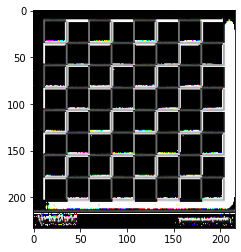

In [ ]:
plt.figure()
plt.imshow(result_image)